In [1]:
# imports
import numpy as np                     # numeric python lib

import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality


# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots

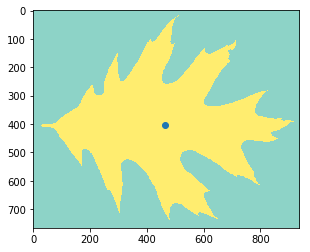

In [2]:
# reading an image file using matplotlib into a numpy array
# good ones: 11, 19, 23, 27, 48, 53, 78, 218
img = mpimg.imread('C:\\Users\\Admin\\ML projects\\images\\11.jpg')

plt.imshow(img, cmap='Set3')


# using image processing module of scipy to find the center of the leaf
cy, cx = ndi.center_of_mass(img)

plt.imshow(img, cmap='Set3')  # show me the leaf
plt.scatter(cx, cy)           # show me its center
plt.show()

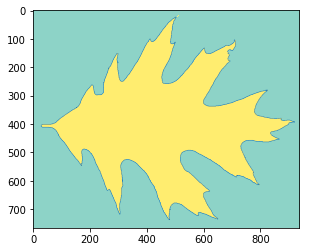

In [3]:
# scikit-learn imaging contour finding, returns a list of found edges
contours = measure.find_contours(img, .8)

# from which we choose the longest one
contour = max(contours, key=len)

# let us see the contour that we hopefully found
plt.plot(contour[::,1], contour[::,0], linewidth=0.5)  # (I will explain this [::,x] later)
plt.imshow(img, cmap='Set3')
plt.show()

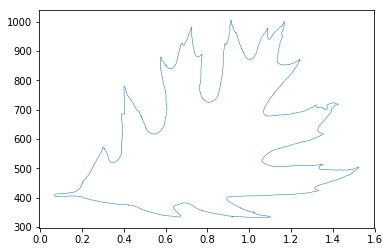

In [4]:
# cartesian to polar coordinates, just as the image shows above
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return [rho, phi]

# just calling the transformation on all pairs in the set
polar_contour = np.array([cart2pol(x, y) for x, y in contour])

# and plotting the result
plt.plot(polar_contour[::,1], polar_contour[::,0], linewidth=0.5)
plt.show()

In [5]:
# numpy is smart and assumes the same about us
# if we substract a number from an array of numbers,
# it assumes that we wanted to substract from all members
contour[::,1] -= cx  # demean X
contour[::,0] -= cy  # demean Y


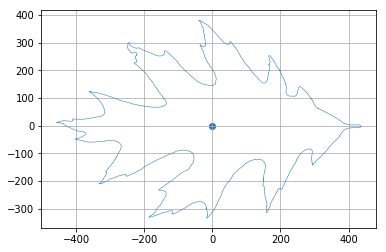

In [6]:
# checking if we succeeded to move the center to (0,0)
plt.plot(-contour[::,1], -contour[::,0], linewidth=0.5)
plt.grid()
plt.scatter(0, 0)
plt.show()

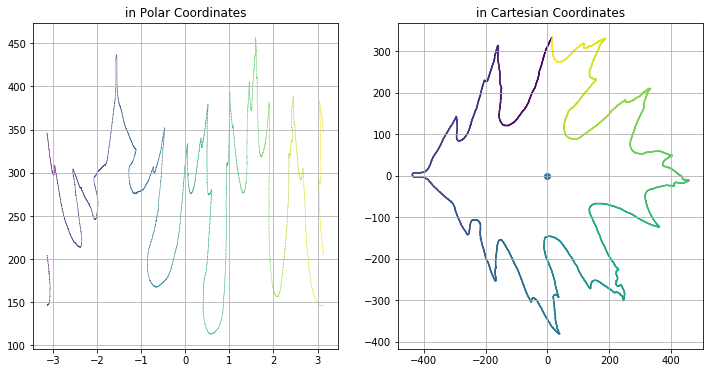

In [7]:
# just calling the transformation on all pairs in the set
polar_contour = np.array([cart2pol(x, y) for x, y in contour])

# and plotting the result
rcParams['figure.figsize'] = (12, 6)
plt.subplot(121)
plt.scatter(polar_contour[::,1], polar_contour[::,0], linewidth=0, s=.5, c=polar_contour[::,1])
plt.title('in Polar Coordinates')
plt.grid()
plt.subplot(122)
plt.scatter(contour[::,1],             # x axis is radians
            contour[::,0],             # y axis is distance from center
            linewidth=0, s=2,          # small points, w/o borders
            c=range(len(contour)))     # continuous coloring (so that plots match)
plt.scatter(0, 0)
plt.title('in Cartesian Coordinates')
plt.grid()
plt.show()

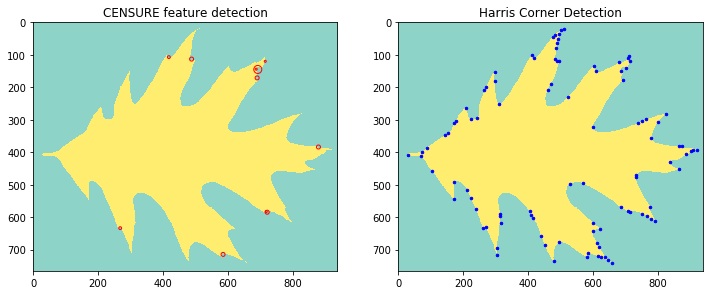

In [8]:
# check a few scikitlearn image feature extractions, if they can help us

from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE

detector = CENSURE()
detector.detect(img)

coords = corner_peaks(corner_harris(img), min_distance=5)
coords_subpix = corner_subpix(img, coords, window_size=13)

plt.subplot(121)
plt.title('CENSURE feature detection')
plt.imshow(img, cmap='Set3')
plt.scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')

plt.subplot(122)
plt.title('Harris Corner Detection')
plt.imshow(img, cmap='Set3')  # show me the leaf
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)
plt.show()

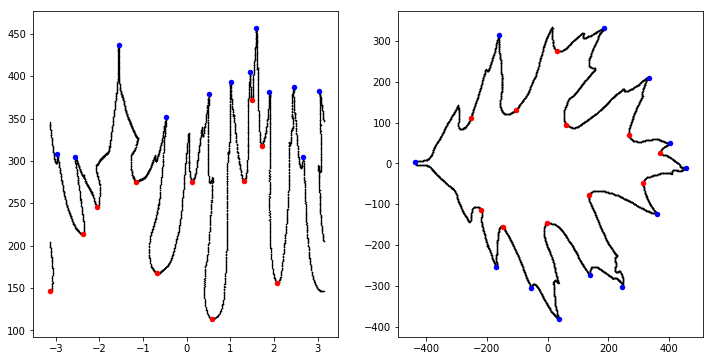

In [9]:
from scipy.signal import argrelextrema

# for local maxima
c_max_index = argrelextrema(polar_contour[::,0], np.greater, order=50)
c_min_index = argrelextrema(polar_contour[::,0], np.less, order=50)

plt.subplot(121)
plt.scatter(polar_contour[::,1], polar_contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(polar_contour[::,1][c_max_index], 
            polar_contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(polar_contour[::,1][c_min_index], 
            polar_contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.subplot(122)
plt.scatter(contour[::,1], contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(contour[::,1][c_max_index], 
            contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(contour[::,1][c_min_index], 
            contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.show()

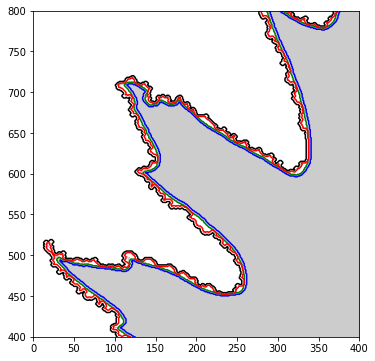

In [10]:
def cont(img):
    return max(measure.find_contours(img, .8), key=len)

# let us set the 'brush' to a 6x6 circle
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]

erosion = cont(ndi.morphology.binary_erosion(img, structure=struct).astype(img.dtype))
closing = cont(ndi.morphology.binary_closing(img, structure=struct).astype(img.dtype))
opening = cont(ndi.morphology.binary_opening(img, structure=struct).astype(img.dtype))
dilation = cont(ndi.morphology.binary_dilation(img, structure=struct).astype(img.dtype))

plt.imshow(img.T, cmap='Greys', alpha=.2)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
#plt.xlim([220, 420])
#plt.ylim([250, 420])
plt.xlim([0, 400])
plt.ylim([400, 800])
plt.show()

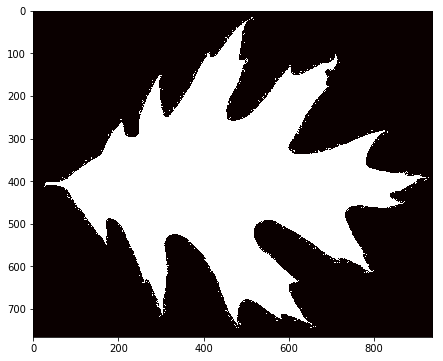

In [11]:
plt.imshow(img.astype(bool).astype(float), cmap='hot')
plt.show()

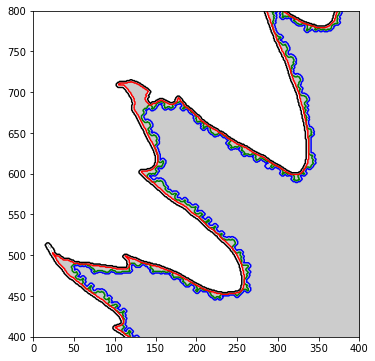

In [12]:
erosion = cont(ndi.morphology.binary_erosion(img > 254, structure=struct).astype(img.dtype))
closing = cont(ndi.morphology.binary_closing(img > 254, structure=struct).astype(img.dtype))
opening = cont(ndi.morphology.binary_opening(img > 254, structure=struct).astype(img.dtype))
dilation = cont(ndi.morphology.binary_dilation(img > 254, structure=struct).astype(img.dtype))

plt.imshow(img.T, cmap='Greys', alpha=.2)
plt.plot(erosion[::,0], erosion[::,1], c='b')
plt.plot(opening[::,0], opening[::,1], c='g')
plt.plot(closing[::,0], closing[::,1], c='r')
plt.plot(dilation[::,0], dilation[::,1], c='k')
plt.xlim([0, 400])
plt.ylim([400, 800])
plt.show()

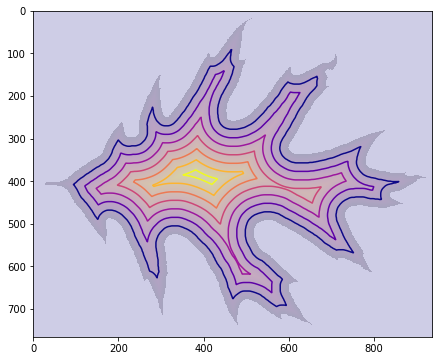

In [13]:
# While I was looking up how to threshold an image, I have found this.
# The further away from the edges a pixel is, the higher value it gets.
# This is important, because it describes the morphology of the leaf better, 
# than a simple euclidean distance from the center, because it considers
# concave parts differently, and that's an important feature I wish to keep.

# This is very promising. Using this, I will probably be able to find symmetry.

# I also believe, that using this distance map, I will be able to separate
# the core shape of the leaf and the edge texture, which are two distinct,
# pretty good features.

dist_2d = ndi.distance_transform_edt(img)
plt.imshow(img, cmap='Greys', alpha=.2)
plt.imshow(dist_2d, cmap='plasma', alpha=.2)
plt.contour(dist_2d, cmap='plasma')
plt.show()